## MMAS 823 Financial Analytics - Individual Assignment 2
### Anthony Ramelo - 20499391

## Part 1: Historical Data and Stock Betas Analysis (12 points)
(1) Data Collection (2 points)

In [62]:
import yfinance as yf
import pandas_datareader as pdr
import datetime as dt

start_date = dt.datetime(2015,1,2)
end_date   = dt.datetime(2025,1,2)  # or present

tickers = ["RACE", "TSLA", "JNJ", "XOM", "^GSPC"]

# 1.1 Download weekly data from Yahoo
data = yf.download(tickers, start=start_date, end=end_date, interval="1wk", auto_adjust=True)
# Alternatively: download daily, then resample to weekly

# 1.2 Extract 'Close' prices (if auto_adjust=True, 'Close' is effectively adjusted)
weekly_close = data["Close"].dropna(how="all")

# 1.3 Download 3-month T-bill from FRED
# For example: "TB3MS" = 3-Month Treasury Bill: https://fred.stlouisfed.org/series/TB3MS
rf_data = pdr.DataReader("TB3MS", "fred", start_date, end_date)
# Resample to match weekly frequency
rf_weekly = rf_data.resample("W-FRI").ffill()  # forward-fill
# Convert from annual % to weekly decimal
rf_weekly["rf_weekly"] = rf_weekly["TB3MS"] / 100.0 / 52.0

[*********************100%***********************]  5 of 5 completed


(2) Beta Estimation (4 points)

In [63]:
import pandas as pd
import statsmodels.api as sm

# 2.1 Compute weekly returns
weekly_returns = weekly_close.pct_change().dropna()

# 2.2 Align risk-free to same index
rf_weekly = rf_weekly.reindex(weekly_returns.index, method="ffill")
risk_free = rf_weekly["rf_weekly"]

# 2.3 Market returns minus risk-free
mkt_excess = weekly_returns["^GSPC"] - risk_free

# 2.4 For each stock, run OLS
for stock in ["RACE", "TSLA", "JNJ", "XOM"]:
    if stock not in weekly_returns.columns:
        # Possibly skip if no data
        continue
    
    stock_excess = weekly_returns[stock] - risk_free
    
    X = sm.add_constant(mkt_excess)
    y = stock_excess
    
    model = sm.OLS(y, X, missing="drop").fit()
    print(f"\n*** Full Sample CAPM: {stock} ***")
    print(model.summary())
    
    # Identify alpha, beta, R^2, etc.
    # alpha = model.params["const"]
    # beta  = model.params["^GSPC"]
    # r2    = model.rsquared
    # etc.


*** Full Sample CAPM: RACE ***
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.05154
Date:                Sat, 01 Feb 2025   Prob (F-statistic):              0.820
Time:                        12:39:06   Log-Likelihood:                 2065.9
No. Observations:                 960   AIC:                            -4128.
Df Residuals:                     958   BIC:                            -4118.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.002

/var/folders/mr/l3x9p9wd385gcyns864s9f2w0000gn/T/ipykernel_93966/4233722595.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  weekly_returns = weekly_close.pct_change().dropna()


(3) Moving Window (Rolling) Regression (6 points)

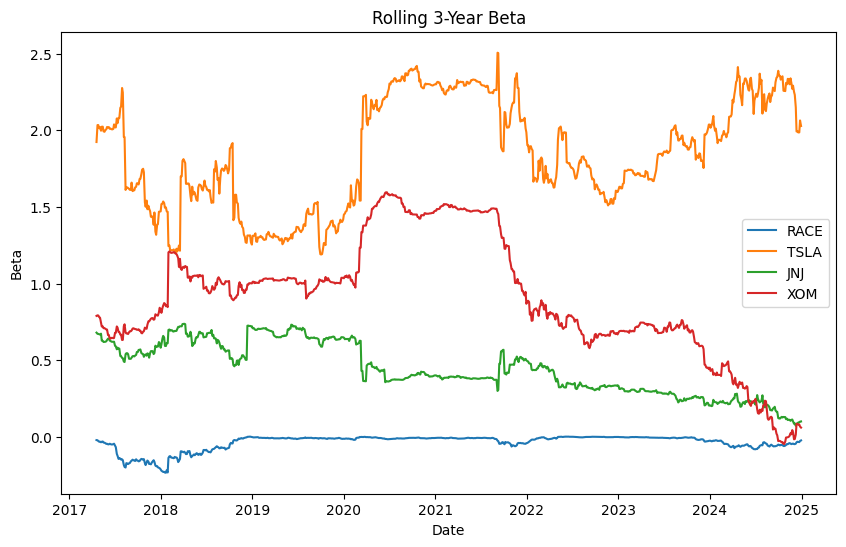

In [60]:
import numpy as np
import matplotlib.pyplot as plt

window_size = 157  # ~3 years of weekly data
rolling_betas = {}

for stock in ["RACE", "TSLA", "JNJ", "XOM"]:
    betas_for_stock = []
    dates_for_stock = []

    stock_excess = weekly_returns[stock] - risk_free
    
    # Only proceed if we have enough data
    if len(stock_excess) < window_size:
        continue
    
    for start_idx in range(len(stock_excess) - window_size + 1):
        end_idx = start_idx + window_size
        # Slice window
        y_win = stock_excess.iloc[start_idx:end_idx]
        X_win = mkt_excess.iloc[start_idx:end_idx]
        
        # Build DF for OLS
        df_win = pd.DataFrame({
            "stock_excess": y_win,
            "mkt_excess": X_win
        }).dropna()
        
        if len(df_win) == 0:
            continue

        # OLS
        X_ols = sm.add_constant(df_win["mkt_excess"])
        y_ols = df_win["stock_excess"]
        model_win = sm.OLS(y_ols, X_ols).fit()
        
        beta_win = model_win.params["mkt_excess"]
        betas_for_stock.append(beta_win)

        # Associate with end of window date
        window_date = df_win.index[-1]
        dates_for_stock.append(window_date)

    # Store as a pandas Series for easy plotting
    rolling_betas[stock] = pd.Series(data=betas_for_stock, index=dates_for_stock)

# Plot rolling betas
plt.figure(figsize=(10,6))
for stock in rolling_betas:
    plt.plot(rolling_betas[stock].index, rolling_betas[stock], label=stock)
plt.legend()
plt.title("Rolling 3-Year Beta")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.show()

Part 